# Custom Convolutional Neural Network (CNN) from Scratch using NumPy

This notebook demonstrates a complete implementation of a Convolutional Neural Network (CNN) from scratch using only NumPy - without relying on high-level libraries like TensorFlow or PyTorch.

<img src="images/Convolution_schematic.gif" style="width:500px;height:300px;">
<caption><center> <u> <font color='purple'></u><font color='purple'>  : <b>Convolution operation</b><br> with a filter of 3x3 and a stride of 1 (stride = amount we move the window each time we slide) </center></caption>
    

### What’s Implemented:
- **Forward Pass**
  - Convolutional layers
  - ReLU activation
  - Max Pooling
  - Flattening
  - Fully Connected (Dense) layer
  - Softmax output

- **Backward Pass**
  - Gradients for all layers using chain rule
  - Backpropagation through Conv, Pool, and Dense layers

- **Training Loop**
  - Forward + backward pass per epoch
  - Cross-entropy loss computation
  - Gradient Descent parameter updates
  - Training loss visualization

- **Testing**
  - Predictions on single/multiple inputs
  - Manual forward/backward shape checks
  - Numerical stability via `log(AL + 1e-8)`

### Dataset: Sign Language Digits
We use a dataset of **RGB images (64x64x3)** representing hand signs for digits **0–5**. Each image is labeled using **one-hot encoding**.  
This task is ideal for evaluating the performance of a CNN in a controlled, small-scale image classification setting.

### Goals of this Project
- Understand CNN internals deeply
- Build forward and backward pass logic manually
- Learn how convolution and pooling interact
- Visualize training performance with loss tracking

---

> **Note:** This implementation is intended for educational purposes and performance/debugging clarity, not for production-scale deep learning.

In [191]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from utils import load_signs_dataset, convert_to_one_hot

In [111]:
def zero_pad(X, pad):
    """
    Pads all images in the dataset X with zeros along height and width.

    Arguments:
    X -- numpy array of shape (m, n_H, n_W, n_C), batch of m images
    pad -- int, padding size to apply on height and width dimensions

    Returns:
    X_pad -- numpy array of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    X_pad = np.pad(
        X,
        pad_width=((0, 0), (pad, pad), (pad, pad), (0, 0)),
        mode='constant',
        constant_values=0
    )
    return X_pad

### Single Step of Convolution 

Implementing a single step of convolution, in which we apply the filter to a single position of the input. This will be used to build a convolutional unit, which: 

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)

In [192]:
def conv_single_step(a_slice_prev, W, b):
    """
    Applies one filter (W, b) to a slice of input data (a_slice_prev).

    Arguments:
    a_slice_prev -- numpy array of shape (f, f, n_C_prev), slice from the input
    W -- numpy array of shape (f, f, n_C_prev), filter weights
    b -- numpy array of shape (1, 1, 1), bias term

    Returns:
    Z -- scalar, result of convolving W on a_slice_prev and adding bias
    """
    s = a_slice_prev * W
    Z = np.sum(s)
    Z = Z + float(b)

    return Z

### Convolutional Neural Networks - Forward Pass

In the forward pass, we will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. We will then stack these outputs to get a 3D volume: 

    
The formulas relating the output shape of the convolution to the input shape are:
    
$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{number of filters used in the convolution}$$

In [193]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward pass of a convolutional layer.

    Arguments:
    A_prev -- numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev), activations from previous layer
    W -- numpy array of shape (f, f, n_C_prev, n_C), filters
    b -- numpy array of shape (1, 1, 1, n_C), biases
    hparameters -- dictionary with keys 'stride' and 'pad'

    Returns:
    Z -- numpy array of shape (m, n_H, n_W, n_C), output of the convolution
    cache -- tuple of values needed for backpropagation
    """

    # Extract dimensions
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, _, _, n_C) = W.shape
    stride = hparameters['stride']
    pad = hparameters['pad']

    # output dimensions
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1

    # output Z
    Z = np.zeros((m, n_H, n_W, n_C))

    # Pad the input
    A_prev_pad = zero_pad(A_prev, pad)

    # convolution
    for i in range(m):  # loop over batch
        a_prev_pad = A_prev_pad[i]     # (n_H_prev, n_W_prev, n_C_prev)
        for h in range(n_H):  # loop over height
            vert_start = h * stride
            vert_end = vert_start + f
            for w in range(n_W):  # loop over width
                horiz_start = w * stride
                horiz_end = horiz_start + f
                for c in range(n_C):  # loop over channels/filters
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    weights = W[:, :, :, c]     
                    bias = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, bias)

    # values for backprop
    cache = (A_prev, W, b, hparameters)

    return Z, cache

## Pooling Layer 

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are: 

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.

These pooling layers have no parameters for backpropagation to train. However, they have hyperparameters such as the window size $f$. This specifies the height and width of the $f \times f$ window we would compute a *max* or *average* over. 

As there's no padding, the formulas binding the output shape of the pooling to the input shape is:

$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_C = n_{C_{prev}}$$

In [194]:
def pool_forward(A_prev, hparameters, mode="max"):
    """
    Implements the forward pass of the pooling layer.

    Arguments:
    A_prev -- numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev), input data
    hparameters -- dictionary containing "f" (filter size) and "stride"
    mode -- string, "max" or "average", specifies the pooling mode

    Returns:
    A -- output of the pooling layer, numpy array of shape (m, n_H, n_W, n_C)
    cache -- tuple of (A_prev, hparameters), used for backprop
    """

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hparameters["f"]
    stride = hparameters["stride"]

    # Output dimensions
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev

    A = np.zeros((m, n_H, n_W, n_C))

    # Pooling operation
    for i in range(m):  # loop over batch
        for h in range(n_H):  # loop over height
            vert_start = h * stride
            vert_end = vert_start + f
            for w in range(n_W):  # loop over width
                horiz_start = w * stride
                horiz_end = horiz_start + f
                for c in range(n_C):  # loop over channels
                    a_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]

                    if mode == "max":
                        A[i, h, w, c] = np.max(a_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_slice)

    # Store cache for backward pass
    cache = (A_prev, hparameters)

    return A, cache

In [201]:
def relu_forward(Z):
    """
    Implements the forward pass of the ReLU activation.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation output, same shape as Z
    cache -- Z, stored for computing backward pass
    """
    A = np.maximum(0, Z)
    cache = Z  # Needed for relu_backward
    return A, cache


In [202]:
def dense_forward(A_prev, W, b):
    """
    Forward pass for a dense (fully connected) layer.

    Computes:
        Z = A_prev · W + b

    Shapes:
    - A_prev: (m, n_in)         # Input from previous layer
    - W:      (n_in, n_out)     # Weights of current layer
    - b:      (1, n_out)        # Biases, broadcasted to (m, n_out)
    - Z:      (m, n_out)        # Linear output

    Returns:
    - Z: Linear output, shape (m, n_out)
    - cache: tuple (A_prev, W, b), for use in backpropagation
    """
    Z = np.dot(A_prev, W) + b
    cache = (A_prev, W, b)
    return Z, cache

## Backpropagation in Convolutional Neural Networks: The Core Idea
At its heart, backpropagation is the application of the chain rule from calculus. When we train a neural network, we want to minimize a cost (or loss) function. To do this, we need to know how much each parameter (weights and biases) contributes to that cost. This "contribution" is measured by the gradient of the cost with respect to that parameter.

The chain rule allows us to compute these gradients by working backward from the output of the network to the input, multiplying the gradients of each layer's output with respect to its input and parameters.

-For a convolutional layer, the forward pass involves:

- Taking a_slice (a patch from the input activation A_prev).

- Performing an element-wise multiplication with a filter W_c.

- Summing the results.

- Adding a bias b_c.

- This gives one element Z_hw in the output feature map Z.

The backward pass reverses this. Given the gradient of the cost with respect to the output Z (denoted as dZ), we need to compute:

- dA_prev: Gradient of the cost with respect to the input activation A_prev.

- dW: Gradient of the cost with respect to the filters W.

- db: Gradient of the cost with respect to the biases b.

# Backpropagation in a Convolutional Layer (From Scratch)

## Why Backprop?
To update the parameters in a convolutional neural network, we must compute how the **loss `J`** changes with respect to:
- the **input** (`dA_prev`)
- the **filter weights** (`dW`)
- the **bias** (`db`)

This is done using **backpropagation** + **chain rule**.

---

## Forward Pass Recap (Single Step)

Each element `Z[i, h, w, c]` is computed as:

$$ Z_{i, h, w, c} = \sum (a_{\text{slice}} \cdot W_c) + b_c $$

Where:
- `a_slice` is a slice from `A_prev` (shape = `(f, f, n_C_prev)`)
- `W_c` is the filter for channel `c`
- `b_c` is the bias

---

## Backward Pass Goal

We are given:
- `dZ[i, h, w, c]`: gradient of cost with respect to `Z[i, h, w, c]`

We need to compute:
- `dA_prev`: Gradient wrt input activations
- `dW`: Gradient wrt filters
- `db`: Gradient wrt biases

---

## Chain Rule Intuition

Let's define the full loss:

$$
J = \text{Loss}(Z) \quad \Rightarrow \quad \frac{\partial J}{\partial A_{\text{prev}}}
$$

By the chain rule:

$$
\frac{\partial J}{\partial A_{\text{prev}}} = \frac{\partial J}{\partial Z} \cdot \frac{\partial Z}{\partial A_{\text{prev}}}
$$

$$
\frac{\partial J}{\partial W} = \frac{\partial J}{\partial Z} \cdot \frac{\partial Z}{\partial W}
\quad ; \quad
\frac{\partial J}{\partial b} = \frac{\partial J}{\partial Z} \cdot \frac{\partial Z}{\partial b}
$$


---

## Concrete Example (Single dZ)

Imagine:
- `a_slice_prev.shape = (f, f, n_C_prev)`
- `W_c.shape = (f, f, n_C_prev)`
- `dZ[i, h, w, c] = 1.5`  ← comes from future layers

Then:
- `dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, :] += W_c * dZ[i, h, w, c]`
- `dW[:, :, :, c] += a_slice_prev * dZ[i, h, w, c]`
- `db[:, :, :, c] += dZ[i, h, w, c]`

> This is repeated over all (i, h, w, c) to accumulate all gradient contributions.



In [203]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function.

    Arguments:
    dZ -- Gradient of cost w.r.t. output Z, shape (m, n_H, n_W, n_C)
    cache -- Tuple of (A_prev, W, b, hparameters) from conv_forward

    Returns:
    dA_prev -- Gradient w.r.t. input A_prev, shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- Gradient w.r.t. weights W, shape (f, f, n_C_prev, n_C)
    db -- Gradient w.r.t. biases b, shape (1, 1, 1, n_C)
    """

    # Unpack cache
    (A_prev, W, b, hparameters) = cache

    # Dimensions
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    (m, n_H, n_W, n_C) = dZ.shape
    stride = hparameters['stride']
    pad = hparameters['pad']

    # Initialize gradients
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)

    # Loop over all training examples
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    # Define the slice's corners
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f

                    # Slice input & corresponding dZ
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    dz = dZ[i, h, w, c]

                    # Compute gradients
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dz
                    dW[:, :, :, c] += a_slice * dz
                    db[:, :, :, c] += dz

        # Unpad for this training example
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :] if pad != 0 else da_prev_pad

    # check
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

    return dA_prev, dW, db

### Backpropagation in Pooling Layers: Masking and Distributing

When performing backpropagation through a **pooling layer**, the way we handle the gradient depends on the **type of pooling** used:

- **Max Pooling**: Only the maximum value in the pooling window affects the output — so only that position gets the gradient.
- **Average Pooling**: All values in the window contribute equally to the output — so the gradient is **evenly distributed** across the window.

We handle these cases with two helper functions:


`create_mask_from_window(x)`  
`distribute_value(dz, shape)`

In [204]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, marking the position of the maximum value.

    Args:
        x (np.ndarray): A window (e.g., a 2D or 3D slice of input activation)
                        from which to create the mask.

    Returns:
        np.ndarray: A boolean mask of the same shape as x, where True indicates
                    the position of the maximum value.
    """
    max_value = np.max(x)
    mask = (x == max_value)

    return mask

In [205]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """    
    (n_H, n_W) = shape
    average = dz / (n_W*n_H)
    a = np.ones(shape) * average
    
    return a

### Putting it Together: Pooling Backward 

We now have everything you need to compute backward propagation on a pooling layer.

In [206]:
def pool_backward(dA, cache, mode="max"):
    """
    Implements the backward pass of the pooling layer.

    Arguments:
    dA -- Gradient of cost w.r.t. the output of the pooling layer, shape (m, n_H, n_W, n_C)
    cache -- Tuple of (A_prev, hparameters), from the forward pass
    mode -- Pooling mode: "max" or "average"

    Returns:
    dA_prev -- Gradient of cost w.r.t. the input of the pooling layer, same shape as A_prev
    """

    A_prev, hparameters = cache
    stride = hparameters["stride"]
    f = hparameters["f"]

    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape

    dA_prev = np.zeros_like(A_prev)

    # Loop over the training examples
    for i in range(m):
        a_prev = A_prev[i]

        for h in range(n_H):             # loop over output height
            for w in range(n_W):         # loop over output width
                for c in range(n_C):     # loop over channels

                    # Find corners of the slice
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f

                    # Select the slice from the input
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]

                        # Create a mask of where the max value was during forward pass
                        mask = create_mask_from_window(a_prev_slice)

                        # Backpropagate only to the max location
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * dA[i, h, w, c]

                    elif mode == "average":
                        # Distribute the gradient equally to all positions
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        distributed = distribute_value(da, shape)

                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distributed

    # check
    assert dA_prev.shape == A_prev.shape

    return dA_prev

In [207]:
def relu_backward(dA, Z):
    """
    Backward pass for ReLU activation.
    
    Arguments:
    dA -- gradient of the cost with respect to the activation
    Z -- pre-activation value (output of conv or dense before ReLU)
    
    Returns:
    dZ -- gradient of the cost with respect to Z
    """
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

- Number of features going into this dense layer = 𝑛_in
- Number of units in the dense layer = 𝑛_out


In [122]:
def dense_backward(dZ, cache):
    """
    Backward pass for a dense (fully connected) layer using cache.
    
    Arguments:
    dZ -- Gradient of cost w.r.t. Z (output of the layer), shape: (m, n_out)
    cache -- Tuple of values (A_prev, W, b) from the forward pass
    
    Returns:
    dA_prev -- Gradient w.r.t. A_prev, shape: (m, n_in)
    dW -- Gradient w.r.t. W, shape: (n_in, n_out)
    db -- Gradient w.r.t. b, shape: (1, n_out)
    """
    A_prev, W, b = cache
    m = A_prev.shape[0]
    
    dW = np.dot(A_prev.T, dZ) / m
    db = np.sum(dZ, axis=0, keepdims=True) / m
    dA_prev = np.dot(dZ, W.T)
    
    return dA_prev, dW, db

### Softmax + Cross-Entropy Backward Derivative

The softmax function is:

$$
\hat{y}_i = \frac{e^{Z_i}}{\sum_{j=1}^{C} e^{Z_j}}
$$

The cross-entropy loss is:

$$
J = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

Combined together for a batch of \( m \) examples:

$$
J = -\frac{1}{m} \sum_{k=1}^{m} \sum_{i=1}^{C} y_i^{(k)} \log(\hat{y}_i^{(k)})
$$

---

By applying the chain rule:

$$
\frac{\partial J}{\partial Z_i} = \frac{\partial J}{\partial \hat{y}_i} \cdot \frac{\partial \hat{y}_i}{\partial Z_i}
$$

But due to the simplification when softmax is **combined** with cross-entropy, we get:

$$
\frac{\partial J}{\partial Z_i} = \hat{y}_i - y_i
$$

---

In vectorized form for all training examples:

$$
\frac{\partial J}{\partial Z} = \frac{1}{m} \left( \hat{Y} - Y \right)
$$

Where:

- $ \hat{Y} \in \mathbb{R}^{(m, C)} $ : softmax outputs  
- $ Y \in \mathbb{R}^{(m, C)} $ : one-hot encoded true labels  
- $ m $ : batch size  


In [208]:
def softmax_cross_entropy_backward(preds, labels):
    """
    Backward pass for softmax with cross-entropy loss.
    Arguments:
    preds -- softmax outputs (A3)   #  (m, n_classes)
    labels -- one-hot encoded true labels (Y)    # (m, n_classes)
    
    Returns:
    dZ3 -- Gradient of the cost w.r.t. Z3
    """
    m = labels.shape[0]
    dZ3 = (preds - labels) / m
    return dZ3  # (m, n_classes)

In [209]:
def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # stability
    return expZ / np.sum(expZ, axis=1, keepdims=True)

In [326]:
def model_forward(X, parameters, epoch=None):
    """
    Implements the full forward pass:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Arguments:
    X -- input image batch, shape: (m, n_H, n_W, n_C)
    parameters -- dictionary containing all weights and biases
    
    Returns:
    AL -- output probabilities (after dense + softmax)
    caches -- list of caches for all layers (for backprop)
    """
    caches = []
  
    # --------- Layer 1: CONV -> RELU -> POOL ----------
    if epoch == 1:
        print("=== Forward Pass ===")
        print("Layer 1: CONV -> RELU -> MAXPOOL")
        print("Input X shape:", X.shape)

    Z1, cache_Z1 = conv_forward(X, parameters["W1"], parameters["b1"], {'stride': 1, 'pad': 2})
    if epoch == 1:
        print("Z1 (after conv1) shape:", Z1.shape)

    A1, cache_A1 = relu_forward(Z1)
    if epoch == 1:
        print("A1 (after relu1) shape:", A1.shape)

    P1, cache_P1 = pool_forward(A1, {'f': 8, 'stride': 8}, mode="max")
    if epoch == 1:
        print("P1 (after pool1) shape:", P1.shape)
        print('-' * 50)

    caches += [cache_Z1, cache_A1, cache_P1]
    
    # --------- Layer 2: CONV -> RELU -> POOL ----------
    if epoch == 1:
        print("Layer 2: CONV -> RELU -> MAXPOOL")

    Z2, cache_Z2 = conv_forward(P1, parameters["W2"], parameters["b2"], {'stride': 1, 'pad': 2})
    if epoch == 1:
        print("Z2 (after conv2) shape:", Z2.shape)

    A2, cache_A2 = relu_forward(Z2)
    if epoch == 1: 
        print("A2 (after relu2) shape:", A2.shape)
   
    P2, cache_P2 = pool_forward(A2, {'f': 4, 'stride': 4}, mode="max")
    if epoch == 1:
        print("P2 (after pool2) shape:", P2.shape)

    caches += [cache_Z2, cache_A2, cache_P2]
    if epoch == 1:
        print('-' * 50)

    # --------- Flatten Layer ----------
    if epoch == 1:
        print("Flatten Layer")
    F = P2.reshape(P2.shape[0], -1)
    if epoch == 1:
        print("F (flattened) shape:", F.shape)

    cache_F = P2
    caches.append(cache_F)

    # --------- Fully Connected (Dense) Layer ----------
    if epoch == 1:
        print("Dense Layer + Softmax")

    Z3, cache_Z3 = dense_forward(F, parameters["W3"], parameters["b3"])
    if epoch == 1:
        print("Z3 (after dense) shape:", Z3.shape)

    A3 = softmax(Z3)
    if epoch == 1:
        print("A3 (after softmax) shape:", A3.shape)

    caches.append(cache_Z3)

    return A3, caches

In [327]:
def model_backward(AL, Y, caches, epoch=None):
    """
    Implements the full backward pass:
    DENSE -> FLATTEN -> MAXPOOL -> RELU -> CONV -> MAXPOOL -> RELU -> CONV

    Arguments:
    AL -- predictions from forward pass, shape (m, n_classes)
    Y -- true labels (one-hot), shape (m, n_classes)
    caches -- list of caches from forward pass

    Returns:
    grads -- dictionary containing gradients for all weights, biases, and activations
    """
    grads = {}

    # Unpack caches
    cache_Z1, cache_A1, cache_P1, \
    cache_Z2, cache_A2, cache_P2, \
    cache_F, cache_Z3 = caches

    if epoch == 1:
        print("=== Backward Pass ===")
        print("AL shape:", AL.shape, " | Y shape:", Y.shape)

    # Last layer: softmax + cross-entropy
    dZ3 = softmax_cross_entropy_backward(AL, Y)
    dA2_flat, dW3, db3 = dense_backward(dZ3, cache_Z3)
    if epoch == 1:
        print("-> Dense backward: dW3:", dW3.shape, ", db3:", db3.shape, ", dA2_flat:", dA2_flat.shape)

    grads["dW3"] = dW3
    grads["db3"] = db3

    # Reshape back to conv output shape
    dP2 = dA2_flat.reshape(cache_F.shape)
    if epoch == 1:
        print("-> Reshape dA2_flat to dP2:", dP2.shape)

    # Backprop through pool2
    dA2 = pool_backward(dP2, cache=(cache_A2, {'f': 4, 'stride': 4}), mode="max")
    if epoch == 1:
        print("-> Pool2 backward: dA2:", dA2.shape)

    # Backprop through ReLU2
    dZ2 = relu_backward(dA2, cache_A2)
    if epoch == 1:
        print("-> ReLU2 backward: dZ2:", dZ2.shape)

    # Backprop through conv2
    dP1, dW2, db2 = conv_backward(dZ2, cache_Z2)
    if epoch == 1:
        print("-> Conv2 backward: dW2:", dW2.shape, ", db2:", db2.shape, ", dP1:", dP1.shape)

    grads["dW2"] = dW2
    grads["db2"] = db2

    # Backprop through pool1
    dA1 = pool_backward(dP1, cache=(cache_A1, {'f': 8, 'stride': 8}), mode="max")
    if epoch == 1:
        print("-> Pool1 backward: dA1:", dA1.shape)

    # Backprop through ReLU1
    dZ1 = relu_backward(dA1, cache_A1)
    if epoch == 1:
        print("-> ReLU1 backward: dZ1:", dZ1.shape)

    # Backprop through conv1
    dX, dW1, db1 = conv_backward(dZ1, cache_Z1)
    if epoch == 1:
        print("-> Conv1 backward: dW1:", dW1.shape, ", db1:", db1.shape, ", dX:", dX.shape)

    grads["dW1"] = dW1
    grads["db1"] = db1
    grads["dX"] = dX

    return grads

In [328]:
def initialize_parameters():
    """
    Initializes weights and biases for the custom CNN:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Returns:
    parameters -- dictionary containing initialized W and b for each layer
    """
    np.random.seed(1)

    parameters = {
        "W1": np.random.randn(5, 5, 3, 8) * 0.1,
        "b1": np.zeros((1, 1, 1, 8)),
        "W2": np.random.randn(5, 5, 8, 16) * 0.1,
        "b2": np.zeros((1, 1, 1, 16)),
        "W3": np.random.randn(64, 6) * 0.1,
        "b3": np.zeros((1, 6))
    }

    return parameters

In [329]:
def train_model(X_train, Y_train, parameters, learning_rate=0.01, num_epochs=20, print_every=1):
    """
    Trains the custom CNN model using forward and backward passes.
    
    Arguments:
    X_train -- training images, shape (m_train, 64, 64, 3)
    Y_train -- one-hot labels, shape (m_train, 6)
    parameters -- initialized model parameters
    learning_rate -- learning rate for gradient descent
    num_epochs -- number of training epochs
    print_every -- prints cost and accuracy every n epochs
    
    Returns:
    parameters -- learned weights and biases after training
    losses -- list of loss values per epoch
    """
    losses = []

    for epoch in range(num_epochs):
        AL, caches = model_forward(X_train, parameters, epoch+1)

        # Compute loss (cross-entropy)
        loss = -np.mean(np.sum(Y_train * np.log(AL + 1e-8), axis=1))
        losses.append(loss)

        # Backward pass
        grads = model_backward(AL, Y_train, caches, epoch+1)

        # Update parameters
        for l in [1, 2, 3]:
            parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
            parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]

        # Print loss every print_every epochs
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {loss:.4f}")

    return parameters, losses

In [330]:
def predict(X, parameters):
    """
    Makes predictions using the trained model.

    Arguments:
    X -- input data, shape (m, 64, 64, 3)
    parameters -- trained weights and biases

    Returns:
    predictions -- numpy array of shape (m,), predicted class indices
    """
    # Forward pass
    AL, _ = model_forward(X, parameters)  # AL: shape (m, 6), probabilities

    # Take argmax across classes (axis=1)
    predictions = np.argmax(AL, axis=1)  # shape (m,)

    return predictions

In [331]:
def predict_accuracy(X, Y_true, parameters):
    """
    Computes the accuracy of the model on given data.

    Arguments:
    X -- input data, shape (m, 64, 64, 3)
    Y_true -- true labels, shape (1, m) or (m,)
    parameters -- trained model parameters

    Returns:
    acc -- accuracy (float between 0 and 1)
    """
    preds = predict(X, parameters)

    if Y_true.ndim == 2 and Y_true.shape[0] == 1:
        Y_true = Y_true.flatten()  # convert (1, m) -> (m,)
    elif Y_true.ndim == 2 and Y_true.shape[1] == 1:
        Y_true = Y_true[:, 0]

    acc = np.mean(preds == Y_true)
    return acc

# Training and Prediction

In [332]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

In [333]:
print ("number of training examples = " + str(X_train_orig.shape[0]))
print ("number of test examples = " + str(X_test_orig.shape[0]))
print ("X_train shape: " + str(X_train_orig.shape))
print ("Y_train shape: " + str(Y_train_orig.shape))
print ("X_test shape: " + str(X_test_orig.shape))
print ("Y_test shape: " + str(Y_test_orig.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1, 1080)
X_test shape: (120, 64, 64, 3)
Y_test shape: (1, 120)


y = 4


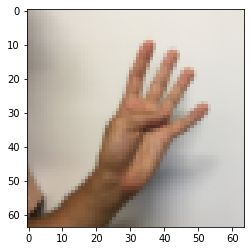

In [334]:
index = 5
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [335]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [336]:
m_train_small = 50
X_train_small = X_train[:m_train_small]    
Y_train_small = Y_train[:m_train_small]    

In [337]:
parameters = initialize_parameters()

In [338]:
trained_params, losses = train_model(X_train_small, Y_train_small, parameters, num_epochs=10, learning_rate=0.01, print_every=1)

=== Forward Pass ===
Layer 1: CONV -> RELU -> MAXPOOL
Input X shape: (50, 64, 64, 3)
Z1 (after conv1) shape: (50, 64, 64, 8)
A1 (after relu1) shape: (50, 64, 64, 8)
P1 (after pool1) shape: (50, 8, 8, 8)
--------------------------------------------------
Layer 2: CONV -> RELU -> MAXPOOL
Z2 (after conv2) shape: (50, 8, 8, 16)
A2 (after relu2) shape: (50, 8, 8, 16)
P2 (after pool2) shape: (50, 2, 2, 16)
--------------------------------------------------
Flatten Layer
F (flattened) shape: (50, 64)
Dense Layer + Softmax
Z3 (after dense) shape: (50, 6)
A3 (after softmax) shape: (50, 6)
=== Backward Pass ===
AL shape: (50, 6)  | Y shape: (50, 6)
-> Dense backward: dW3: (64, 6) , db3: (1, 6) , dA2_flat: (50, 64)
-> Reshape dA2_flat to dP2: (50, 2, 2, 16)
-> Pool2 backward: dA2: (50, 8, 8, 16)
-> ReLU2 backward: dZ2: (50, 8, 8, 16)
-> Conv2 backward: dW2: (5, 5, 8, 16) , db2: (1, 1, 1, 16) , dP1: (50, 8, 8, 8)
-> Pool1 backward: dA1: (50, 64, 64, 8)
-> ReLU1 backward: dZ1: (50, 64, 64, 8)
-> Co

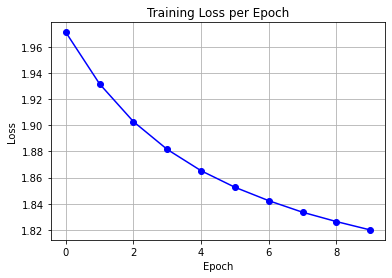

In [339]:
plt.plot(losses, marker='o', color='blue')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()